In [1]:
# Step 1: Setup and Install Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch.nn as nn
import matplotlib.pyplot as plt
import string
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification
from transformers import AdamW
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Step 2: Mount Google Drive and Load Dataset
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# # Define the path to the dataset (ensure there's no trailing space)
# dataset_path = "/content/drive/MyDrive/Fake news /pakistani_dataset_consolidated.xlsx"

# # Assign the loaded DataFrame to 'train_df'
# train_df = pd.read_excel(dataset_path)  # Changed df to train_df

# train_df.head()

# Load the dataset
dataset_path ="/content/drive/MyDrive/Fake news /pakistani_dataset_consolidated.xlsx"
df = pd.read_excel(dataset_path)

Mounted at /content/drive


In [3]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12008 entries, 0 to 12007
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   URL             11296 non-null  object
 1   Title           11913 non-null  object
 2   Text            12007 non-null  object
 3   Review Date     1584 non-null   object
 4   Textual Rating  12008 non-null  object
 5   Publisher Site  4183 non-null   object
 6   Publisher Name  11351 non-null  object
 7   Claim Date      1500 non-null   object
 8   Claimant        1431 non-null   object
 9   Content         9115 non-null   object
 10  Published At    9906 non-null   object
 11  Author          8379 non-null   object
 12  Url to Image    9198 non-null   object
dtypes: object(13)
memory usage: 1.2+ MB
None


In [4]:
df.head()

,URL,Title,Text,Review Date,Textual Rating,Publisher Site,Publisher Name,Claim Date,Claimant,Content,Published At,Author,Url to Image
0,https://factcheck.afp.com/satirical-claim-abou...,NaN,Pakistan passes law making two marriages for m...,2021-01-12T11:55:00Z,Satire,factcheck.afp.com,AFP Fact Check,2020-11-05T00:00:00Z,Multiple Sources,NaN,NaN,NaN,NaN
1,https://thelogicalindian.com/fact-check/balako...,NaN,Ex Pakistani diplomat in a debate accepted tha...,2021-01-11T11:19:26Z,False,thelogicalindian.com,The Logical Indian,2021-01-11T11:19:26Z,Social Media,NaN,NaN,NaN,NaN
2,https://www.altnews.in/indian-media-falsely-cl...,Indian media falsely claims ex-Pak diplomat ad...,Former Pakistani diplomat Zafar Hilaly admitte...,2021-01-10T00:00:00Z,False,altnews.in,Alt News,2016-06-20T00:00:00Z,"ANI, Republic, Times of India, Livemint, ABP N...",NaN,NaN,NaN,NaN
3,https://www.boomlive.in/fact-check/fact-check-...,"ANI, News Outlets Falsely Claim Ex Pak Diploma...",Former Pak diplomat admits 300 casualties in B...,2021-01-10T11:38:27Z,False,boomlive.in,BOOM FACT Check,2021-01-10T11:38:27Z,"ANI, Republic TV, CNN News 18, NE Now, Livemin...",NaN,NaN,NaN,NaN
4,https://www.boomlive.in/fact-check/fake-news-f...,Dawn Screenshot Claiming Pakistani Pilot Urina...,Photo shows Dawn article on Pakistan pilot uri...,2021-01-04T08:41:24Z,False,boomlive.in,BOOM FACT Check,2021-01-04T08:41:24Z,Facebook Posts,NaN,NaN,NaN,NaN


In [5]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
URL                 712
Title                95
Text                  1
Review Date       10424
Textual Rating        0
Publisher Site     7825
Publisher Name      657
Claim Date        10508
Claimant          10577
Content            2893
Published At       2102
Author             3629
Url to Image       2810
dtype: int64


In [6]:
# Drop rows where 'Text' is missing since it's essential
data = df.dropna(subset=['Text'])

In [7]:
#Fill missing categorical columns with "Unknown" (if retaining them)
categorical_columns = ['Title', 'Publisher Site', 'Publisher Name', 'Claimant', 'Content', 'Author', 'Url to Image']
data[categorical_columns] = data[categorical_columns].fillna('Unknown')

<ipython-input-7-bf5c2ae3277a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[categorical_columns] = data[categorical_columns].fillna('Unknown')


In [8]:
# Drop less critical columns with high missing percentages
columns_to_drop = ['URL', 'Review Date', 'Claim Date']
data = data.drop(columns=columns_to_drop, axis=1)

In [9]:
# Verify remaining missing values
print("\nRemaining Missing Values After Handling:")
print(data.isnull().sum())


Remaining Missing Values After Handling:
Title                0
Text                 0
Textual Rating       0
Publisher Site       0
Publisher Name       0
Claimant             0
Content              0
Published At      2102
Author               0
Url to Image         0
dtype: int64


In [10]:
print("Column Names:")
print(data.columns.tolist())

Column Names:
['Title', 'Text', 'Textual Rating', 'Publisher Site', 'Publisher Name', 'Claimant', 'Content', 'Published\xa0At', 'Author', 'Url to Image']


In [11]:
# Replace non-breaking spaces in column names
data.columns = data.columns.str.replace('\xa0', ' ', regex=False)

# Verify the column names
print("Cleaned Column Names:")
print(data.columns)

Cleaned Column Names:
Index(['Title', 'Text', 'Textual Rating', 'Publisher Site', 'Publisher Name',
       'Claimant', 'Content', 'Published At', 'Author', 'Url to Image'],
      dtype='object')


In [12]:
# Fill missing dates in 'Published At' with the most frequent date (mode)
data['Published At'] = data['Published At'].fillna(data['Published At'].mode()[0])

In [13]:
print("\nFinal Check for Missing Values:")
print(data.isnull().sum())


Final Check for Missing Values:
Title             0
Text              0
Textual Rating    0
Publisher Site    0
Publisher Name    0
Claimant          0
Content           0
Published At      0
Author            0
Url to Image      0
dtype: int64


In [14]:
# Distribution of 'Textual Rating' (e.g., True, False, Satire)
print("\nTextual Rating Distribution:")
print(data['Textual Rating'].value_counts())


Textual Rating Distribution:
Textual Rating
True                                  9985
False                                 1339
FALSE                                  227
False                                   78
Mostly false                            69
                                      ... 
False: Famous Pak Chacha is alive.       1
The man in the video is Russian.         1
Misleading and false.                    1
Misleading Claim                         1
false                                    1
Name: count, Length: 61, dtype: int64


In [15]:
print("Unique Categories:")
print(data['Textual Rating'].unique())

Unique Categories:
['Satire' 'False' 'Half true' 'Half True' 'Misleading' 'FALSE'
 'Mostly false' 'True' 'Suspicious' 'Hard to Categorise' 'Fake' 'SATIRE'
 'FAKE' False 'Explainer'
 'The claim is false. The video was actually a scene from a film called Load Wedding.'
 'False. The video used as evidence for this statement shows an attack on a church in Egypt in 2013.'
 'Unclear' 'MISLEADING' '1' 'False: This is an Old Image of 2017'
 'Mixture' 'The picture in question is NOT from Kashmir.' 'PARTLY TRUE'
 'TRUE' 'UNVERIFIED' 'FASLE'
 'The horrific video in question is from Karachi, Pakistan and not from Hyderabad.'
 'False.'
 'Our investigation established that the video in question is five years old and it has no connection with the ongoing lockdown due to COVID-19.'
 "FAKE. It's morphed."
 "The above is a FAKE vs REAL collage, it is clear that Mamata Banerjee and Imran Khan's faces were superimposed on the original picture using photo editing software."
 'Mixed' 'False: Famous Pak Chac

In [16]:
# Normalize text: lowercase and remove punctuation
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

In [17]:
# Create a function to map detailed labels to broader categories
def map_to_broad_category(label):
    if 'true' in label:
        return 'true'
    elif 'false' in label or 'fake' in label or 'doctored' in label or 'fasle' in label or 'altered' in label:
        return 'false'
    elif 'misleading' in label or 'mixture' in label or 'mixed' in label or 'milsleading' in label:
        return 'misleading'
    elif 'satire' in label:
        return 'satire'
    elif 'unclear' in label or 'explainer' in label or 'hard to categorise' in label or 'unverified' in label:
        return 'unclear'
    else:
        return 'other'

In [18]:
# Clean the Textual Rating column
import string
data['Textual Rating'] = data['Textual Rating'].astype(str).apply(clean_text)

In [19]:
# Create a new column for broader categories
data['Broad Category'] = data['Textual Rating'].apply(map_to_broad_category)

In [20]:
# Verify the cleaned and categorized data
print("Broad Category Distribution:")
print(data['Broad Category'].value_counts())

Broad Category Distribution:
Broad Category
true          10055
false          1789
misleading       89
other            55
unclear          14
satire            5
Name: count, dtype: int64


In [21]:
# Check rows
print(data[['Textual Rating', 'Broad Category']].head())

  Textual Rating Broad Category
0         satire         satire
1          false          false
2          false          false
3          false          false
4          false          false


In [22]:

# Data Preprocessing: Select relevant columns and map labels to binary classes
df = df[['Text', 'Textual Rating']].dropna()  # Drop rows with missing values
df['Label'] = df['Textual Rating'].apply(lambda x: 0 if isinstance(x, str) and x.lower() in ['false', 'fake', 'satire'] else 1)

In [23]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df['Text'], df['Label'], test_size=0.2, random_state=42)

In [24]:
# Define a custom dataset class for BERT
import torch
from torch.utils.data import Dataset

class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [25]:
# Initialize the tokenizer and create DataLoader instances
from transformers import BertTokenizer, AutoTokenizer

from torch.utils.data import DataLoader

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = FakeNewsDataset(X_train, y_train, tokenizer)
val_dataset = FakeNewsDataset(X_val, y_val, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [26]:
# Initialize the BERT model for classification
from transformers import BertTokenizer, BertForSequenceClassification # Import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [27]:
# Define the optimizer and loss function
from torch.optim import AdamW
import torch.nn as nn
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()


In [28]:
# Training and validation loop
train_losses = []
val_losses = []
val_accuracies = []

epochs = 3  # Adjust as needed
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            labels=batch['labels']
        )

        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch + 1}/{epochs}, Average Training Loss: {avg_train_loss:.4f}')


KeyboardInterrupt: 

In [ ]:
# Validation step
model.eval()
val_loss = 0
correct_predictions = 0

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == batch['labels'])
        val_loss += loss_fn(logits, batch['labels']).item()

avg_val_loss = val_loss / len(val_loader)
val_losses.append(avg_val_loss)
val_accuracy = correct_predictions.double() / len(val_dataset)
val_accuracies.append(val_accuracy.item())

print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}')






Validation Loss: 0.1269, Accuracy: 0.9434


In [ ]:
# Generate a classification report
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

In [ ]:
# Print the classification report
report = classification_report(all_labels, all_preds, target_names=['Fake', 'Real'])
print(report)

              precision    recall  f1-score   support

        Fake       0.74      0.87      0.80       315
        Real       0.98      0.95      0.97      2087

    accuracy                           0.94      2402
   macro avg       0.86      0.91      0.88      2402
weighted avg       0.95      0.94      0.95      2402



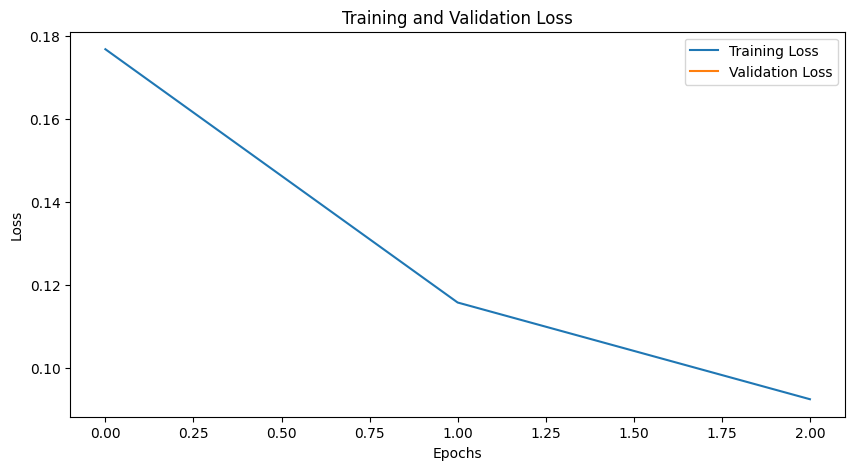

In [ ]:
# # Plot training and validation loss curves
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()
# Plot Training and Validation Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()


In [ ]:
# # Plot Training and Validation Accuracy Curve
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')  # Plot training accuracy
# plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')  # Plot validation accuracy
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy Curve')
# plt.legend()
# plt.show()


 #Plot accuracy graphs dynamically based on epochs
plt.figure()
plt.plot(train_acc_list, label='Training Accuracy', marker='o')
plt.plot(test_acc_list, label='Testing Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(len(train_acc_list)))  # Ensure each epoch is represented on the x-axis
plt.legend()
plt.title('Training and Testing Accuracy')
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

In [ ]:
# Plot Training & Testing Accuracy over Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Testing Accuracy over Epochs')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()

In [ ]:
# # Plot validation accuracy curve
# plt.figure(figsize=(10, 5))
# plt.plot(val_accuracies, label='Validation Accuracy', marker='o', linestyle='-', color='b')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Validation Accuracy Curve')
# plt.legend()
# plt.grid(True)  # Add grid lines for better readability
# plt.show()

# Plot Validation Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

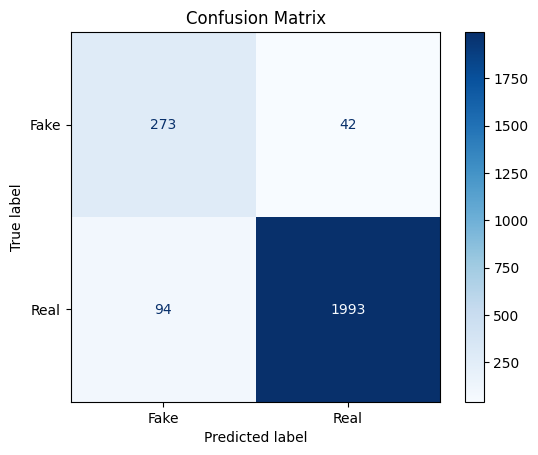

In [ ]:
# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, display_labels=['Fake', 'Real'], cmap='Blues')
plt.title('Confusion Matrix')
plt.show()